In [90]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from tqdm import tqdm_notebook
import os 
from scapy.all import *
import pandas as pd
from multiprocessing import Pool

In [ ]:
def get_df_from_dir(file_path,contain_string):
    """
        将指定目录中包含指定内容的csv的全部内容融合成一个dataframe
        :param file_path:要合并成一个的文件目录
        :param contain_string:其中要包含的字符串
        :return df:合并后的dataframe
    """
    #读取包含指定字符串的文件名列表
    file_name_list = []
    for file_name in os.listdir(file_path):
        file_name = os.path.join(file_path+file_name)
        if re.search(contain_string,file_name)!=None:
            file_name_list.append(k)

    df = pd.DataFrame()
    for file_name in tqdm_notebook(file_name_list[0]):    
        tmp_df = pd.read_csv(FILE_PATH+file_name)
        df = pd.concat([df,tmp_df])
    df = df.reset_index(drop=True).drop('Unnamed: 0',axis=1)
    
    return df

def extract_payload_feature(payload):
    """
        从未知协议流量的payload中提取特征，包括ba、可见字符数量、大小写字母的数量、数字个数、其他数量的等
        param payload:传输层的payload
        return 提取到的特征列表
    """
    
    if payload is None:
        return "", 0, 0, 0, 0, 0, 0, 0
    ba = bytearray.fromhex(payload)
    visible = 0
    uppercase_alpha = 0
    lowercase_alpha = 0
    digit = 0
    others = 0
    invisible = 0
    non_ascii = 0

    for b in ba:
        if b in range(0x20, 0x7E + 1):
            visible += 1
            if b in range(0x41, 0x5A + 1):
                uppercase_alpha += 1
            elif b in range(0x61, 0x7A + 1):
                lowercase_alpha += 1
            elif b in range(0x30, 0x39 + 1):
                digit += 1
            else:
                others += 1
        elif b in range(0x00, 0x19 + 1) or b == 0x7F:
            invisible += 1
        else:
            non_ascii += 1
    
    statistic_feature_list.append([payload,ba, visible, uppercase_alpha, lowercase_alpha, digit, others, invisible, non_ascii])
    return payload,ba, visible, uppercase_alpha, lowercase_alpha, digit, others, invisible, non_ascii



In [ ]:
#=========从文件夹中读取数据===============
FILE_PATH ="/media/SSD/yhk/tmp_csv/"
df = get_df_from_dir(FILE_PATH,"272")

#=========提取特征====================
statistic_feature_list = []
tmp = df.payload_original.apply(lambda x:extract_payload_feature(x))
columns = ['payload_original','payload','visible', 'uppercase_alpha', 'lowercase_alpha',' digit', 'others', 'invisible', 'non_ascii']
statistic_feature_df = pd.DataFrame(statistic_feature_list,columns=columns)
statistic_feature_df['len'] =statistic_feature_df.payload_original.apply(lambda x:len(x)/2)
data = pd.concat([df[['src','dst','time']],statistic_feature_df],axis=1)


#=============================
#      获取pcap包内基本信息
#=============================

max_len = 10000
min_len = 1

print("正在获取pcap包基本信息...")

Conversion_list = []
for index,row in data.iterrows():
    if ([row.src,row.dst] not in Conversion_list)&([row.dst,row.src] not in Conversion_list):
        Conversion_list.append([row.src,row.dst])

print("pcap文件中包含的总报文数：{}".format(data.shape[0]))
print("pcap文件中包含的通信主机数：{}".format(len(Conversion_list)))
print("pcap文件中包含的小于{}字节的报文数:{}".format(max_len,len(data[data.len<=max_len])))
print("pcap文件中包含的小于{}字节且大于{}字节的报文数:{}".format(max_len,min_len,len(data[(data.len<=max_len)&(data.len>min_len)])))

# 根据长度过滤
data = data[(data.len<=max_len)&(data.len>min_len)].reset_index(drop=True)

# 获取指定输入格式
input = data.ix[:,5:]

#===============使用DBSCAN进行聚类======================
dbscan = DBSCAN(min_samples=1,eps=1.8)
predict = dbscan.fit_predict(input)
predict_df = pd.DataFrame(predict,columns = ['label'])
output = pd.concat([data,predict_df],axis=1)

In [61]:
#======================
#    打印聚类结果报告
#======================
print("聚类簇数：{}".format(len(set(predict))-1))
print("----------------------------------------")
for i in set(predict):
    locals()["cluster"+str(i)] = output[dbscan.labels_==i]
    packets_nums = locals()["cluster"+str(i)].shape[0]
    unique_packets_nums = len(set(locals()["cluster"+str(i)].payload_original))
    connect_nums = locals()["cluster"+str(i)][["src","dst"]].drop_duplicates().shape[0]
    if i==-1:
        print("-"*40)
        print("未成功聚类的报文个数：{}，其中不重复的报文个数：{},属于{}个会话".format(packets_nums,unique_packets_nums,connect_nums))
    else:
        print(" ")
        print("cluster {} 包括{}个报文，不重复的报文个数：{},属于{}个会话".format(i,packets_nums,unique_packets_nums,connect_nums))
        
        

聚类簇数：13
----------------------------------------
 
cluster 0 包括3385个报文，不重复的报文个数：1,属于369个会话
 
cluster 1 包括1758个报文，不重复的报文个数：1,属于7个会话
 
cluster 2 包括12个报文，不重复的报文个数：1,属于1个会话
 
cluster 3 包括1个报文，不重复的报文个数：1,属于1个会话
 
cluster 4 包括38个报文，不重复的报文个数：1,属于7个会话
 
cluster 5 包括34个报文，不重复的报文个数：34,属于6个会话
 
cluster 6 包括1个报文，不重复的报文个数：1,属于1个会话
 
cluster 7 包括1个报文，不重复的报文个数：1,属于1个会话
 
cluster 8 包括3个报文，不重复的报文个数：1,属于1个会话
 
cluster 9 包括1个报文，不重复的报文个数：1,属于1个会话
 
cluster 10 包括201个报文，不重复的报文个数：1,属于2个会话
 
cluster 11 包括8个报文，不重复的报文个数：1,属于1个会话
 
cluster 12 包括1个报文，不重复的报文个数：1,属于1个会话
 
cluster 13 包括1个报文，不重复的报文个数：1,属于1个会话


In [64]:
#============================
#     查验各类内数据情况
#============================
N =0    #指定查看类
view_data = locals()["cluster"+str(N)]
packets_nums = view_data.shape[0]
unique_packets_nums = len(set(view_data.payload_original))

print("cluster {} 包括{}个报文，不重复的报文个数：{},属于{}个会话".format(N,packets_nums,unique_packets_nums,connect_nums))
print(" ")

print("-------------类内包含的payload表----------------")
print(view_data[['payload_original']].drop_duplicates())
print(" ")

print("--------------各个会话的通信数量表----------------")
print(view_data.groupby(['src','dst']).count()[['payload']].reset_index().rename(columns={'payload':'packets_nums'}))
print(" ")

print("--------------各个会话中不同payload发送次数表--------")
print(view_data.groupby(['src','dst','payload_original']).count()[['payload']].reset_index().rename(columns={'paylaod':'packets_nums'}))

cluster 0 包括3385个报文，不重复的报文个数：1,属于1个会话
 
-------------类内包含的payload表----------------
                               payload_original
0  63623173741600000001000000789c33040000320032
 
--------------各个会话的通信数量表----------------
                 src              dst  packets_nums
0     104.148.15.171        1.85.3.90             4
1     104.148.15.171  116.255.159.234             4
2     104.148.15.171   116.255.185.84            10
3     104.148.15.171  118.123.167.241            12
4     104.148.15.171     121.40.24.29             5
5     104.148.15.171   122.114.155.60             4
6     104.148.15.171    124.94.117.64             5
7     104.148.15.171   171.92.207.131             5
8     104.148.15.171    218.246.23.46             4
9     104.148.15.171    219.247.104.5             5
10    104.148.15.171     221.4.197.51             5
11    104.148.15.171      60.6.215.60             8
12   107.151.128.138  116.213.200.250            11
13   107.151.128.138    125.64.38.190             

In [65]:
#============================
#      获取时间间隔三元组
#===========================
def get3Interval(time_list):
    interval_list = []
    for i in range(len(time_list)):
        if i==0:
            interval1 = 0
            interval2 = 0
            interval3 = 0
        elif i==1:
            interval1 = (round(time_list[i]-time_list[i-1]))
            interval2 = 0
            interval3 = 0
        elif i==2:
            interval1 = (round(time_list[i]-time_list[i-1]))
            interval2 = (round(time_list[i]-time_list[i-2]))
            interval3 = 0
        else:
            interval1 = (round(time_list[i]-time_list[i-1]))
            interval2 = (round(time_list[i]-time_list[i-2]))
            interval3 = (round(time_list[i]-time_list[i-3]))
        interval_list.append([interval1,interval2,interval3])
    return interval_list

#============================================
#      获取相同时间间隔数量最多的时间间隔和数量
#============================================
def getMaxInterval(interval_list):
    interval_num = {}

    for interval_tri in interval_list:
        same=[]
        for interval in interval_tri:
            if interval!=0:
                if interval not in interval_num:
                    interval_num[interval] = 1
                elif interval not in same:
                    interval_num[interval] +=1
                same.append(interval)
    max_num = 0
    max_num_interval = 0
    for i in interval_num:
        if i>10:
            if interval_num[i]>max_num:
                max_num =interval_num[i]
                max_num_interval = i
    return max_num_interval,max_num

In [66]:
cluster_label_list = list(output['label'].drop_duplicates())
if -1 in cluster_label_list:
    cluster_label_list.remove(-1)
cluster_label_list.sort()
cluster_label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [67]:
for i in range(len(cluster_label_list)):
    locals()['label'+str(i)] = output[output.label==i]
    ips_List = locals()['label'+str(i)][['src','dst']].drop_duplicates().values
    print("label {}.....".format(i))
    for ips in ips_List:
        src = ips[0]
        dst = ips[1]
        df_ips = locals()['label'+str(i)][(locals()['label'+str(i)].src==src)&(locals()['label'+str(i)].dst==dst)]
        time_list = list(df_ips.time)
        packets_num = len(time_list)
        interval_list = get3Interval(time_list)
        max_interval,max_interval_num = getMaxInterval(interval_list)
        print("{}->{} has {} similar packets，{} interval number is most，have {}".format(
            src,dst,packets_num,max_interval,max_interval_num))

label 0.....
185.224.170.130->122.224.179.250 has 10 similar packets，0 interval number is most，have 0
185.224.170.130->219.153.51.16 has 5 similar packets，0 interval number is most，have 0
104.148.15.171->116.255.185.84 has 10 similar packets，0 interval number is most，have 0
180.150.230.204->119.10.67.237 has 5 similar packets，0 interval number is most，have 0
104.148.15.171->60.6.215.60 has 8 similar packets，0 interval number is most，have 0
180.150.230.204->125.67.237.162 has 5 similar packets，0 interval number is most，have 0
185.224.170.130->183.61.166.123 has 4 similar packets，0 interval number is most，have 0
107.151.128.142->61.170.134.167 has 6 similar packets，120 interval number is most，have 5
185.224.170.130->119.147.101.223 has 14 similar packets，0 interval number is most，have 0
185.224.170.130->180.153.46.207 has 6 similar packets，120 interval number is most，have 5
107.151.128.142->220.163.10.126 has 4 similar packets，0 interval number is most，have 0
185.224.170.130->219.153.48.

185.224.170.130->60.191.37.82 has 5 similar packets，0 interval number is most，have 0
185.224.170.130->180.101.186.26 has 5 similar packets，0 interval number is most，have 0
185.224.170.130->59.36.96.13 has 4 similar packets，0 interval number is most，have 0
185.224.170.130->101.254.156.57 has 5 similar packets，0 interval number is most，have 0
61.183.52.22->34.234.36.131 has 4 similar packets，0 interval number is most，have 0
107.151.128.142->222.73.204.18 has 5 similar packets，150 interval number is most，have 4
185.224.170.130->117.135.136.111 has 10 similar packets，0 interval number is most，have 0
61.183.52.22->211.214.27.211 has 5 similar packets，0 interval number is most，have 0
180.150.230.204->218.72.250.10 has 8 similar packets，0 interval number is most，have 0
185.224.170.130->61.177.148.186 has 25 similar packets，0 interval number is most，have 0
180.150.230.204->119.10.58.109 has 10 similar packets，0 interval number is most，have 0
185.224.170.130->101.81.64.133 has 10 similar packet

180.150.230.204->61.152.175.41 has 4 similar packets，0 interval number is most，have 0
185.224.170.130->180.153.19.98 has 1 similar packets，0 interval number is most，have 0
107.151.128.142->112.31.135.199 has 3 similar packets，0 interval number is most，have 0
23.88.165.22->123.57.172.248 has 5 similar packets，0 interval number is most，have 0
45.124.112.205->122.226.85.190 has 5 similar packets，122 interval number is most，have 4
182.16.73.141->210.14.128.18 has 4 similar packets，0 interval number is most，have 0
185.224.170.130->180.175.150.178 has 5 similar packets，150 interval number is most，have 4
112.121.185.150->117.21.200.59 has 5 similar packets，150 interval number is most，have 4
185.224.170.130->218.1.107.106 has 5 similar packets，150 interval number is most，have 4
107.151.128.138->202.100.206.141 has 4 similar packets，0 interval number is most，have 0
185.224.170.130->202.91.242.30 has 4 similar packets，0 interval number is most，have 0
45.124.112.205->59.44.131.103 has 10 similar 

185.224.170.130->218.75.94.226 has 5 similar packets，0 interval number is most，have 0
185.224.170.130->221.226.82.226 has 12 similar packets，0 interval number is most，have 0
185.224.170.130->180.153.157.45 has 5 similar packets，150 interval number is most，have 4
label 1.....
185.224.170.130->183.60.227.32 has 99 similar packets，0 interval number is most，have 0
185.224.170.130->14.17.86.27 has 195 similar packets，0 interval number is most，have 0
185.224.170.130->119.147.144.67 has 73 similar packets，0 interval number is most，have 0
185.224.170.130->49.65.1.114 has 1091 similar packets，0 interval number is most，have 0
185.224.170.130->218.16.123.227 has 102 similar packets，0 interval number is most，have 0
185.224.170.130->218.16.120.40 has 99 similar packets，0 interval number is most，have 0
185.224.170.130->124.115.205.140 has 99 similar packets，0 interval number is most，have 0
label 2.....
180.150.230.204->103.21.143.228 has 12 similar packets，0 interval number is most，have 0
label 3...

#### 效果可视化

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=100)
x = tsne.fit_transform(input)

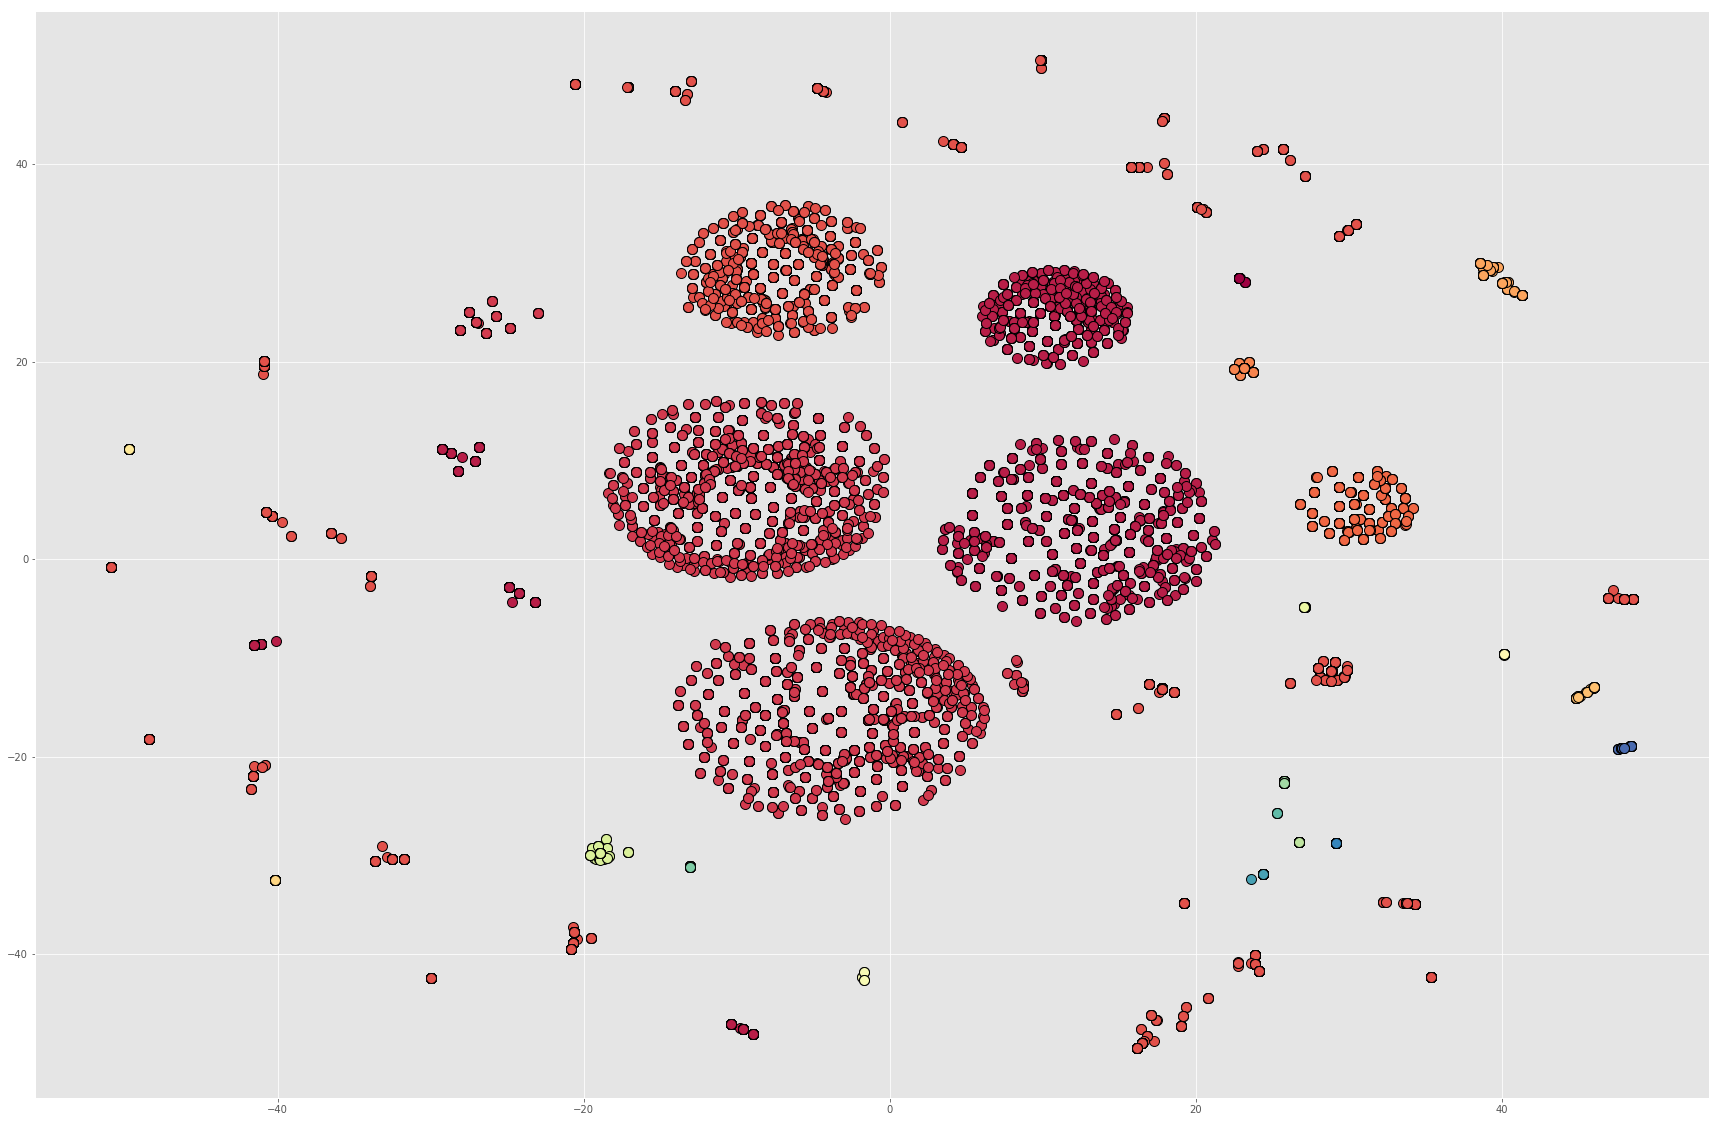

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate=100)
x = tsne.fit_transform(input)


labels = dbscan.labels_
unique_labels = set(dbscan.labels_)

colors = plt.cm.Spectral(np.linspace(0,1,len(set(dbscan.labels_))))
core_samples_mask =np.zeros_like(dbscan.labels_,dtype=bool)

core_samples_mask[dbscan.core_sample_indices_] = True




plt.style.use('ggplot') 
plt.figure(figsize=(30,20)) 
for k,col in zip(unique_labels,colors):
    if k==-1:
        col='k'
    class_member_mask = (labels==k)
    xy = x[class_member_mask & core_samples_mask]
    plt.plot(xy[:,0],xy[:,1],'o',markerfacecolor=col,markeredgecolor='k',markersize=10)
#xy = X[class_member_mask & ~core_samples_mask]